# Extended Attn vs Conv CNP

Last Update : 12 July 2019

**Aim**: 
- Extensively compare the proposed extended attentive and convolutional CNP


In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

To DO:
- images
- more details about the varying hyperparam

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [16]:
%%time

from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples
from ntbks_helpers import get_gp_datasets, get_gp_datasets_varying # defined in first tutorial (CNP)

X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less
N_DIFF_HYP = 1000
MAX_EPOCHS = 50
datasets = get_gp_datasets_varying(n_samples=N_SAMPLES, n_points=N_POINTS, 
                                   n_diff_kernel_hyp=N_DIFF_HYP, save_file='data/gp_dataset.hdf5')

CPU times: user 12 ms, sys: 168 ms, total: 180 ms
Wall time: 183 ms


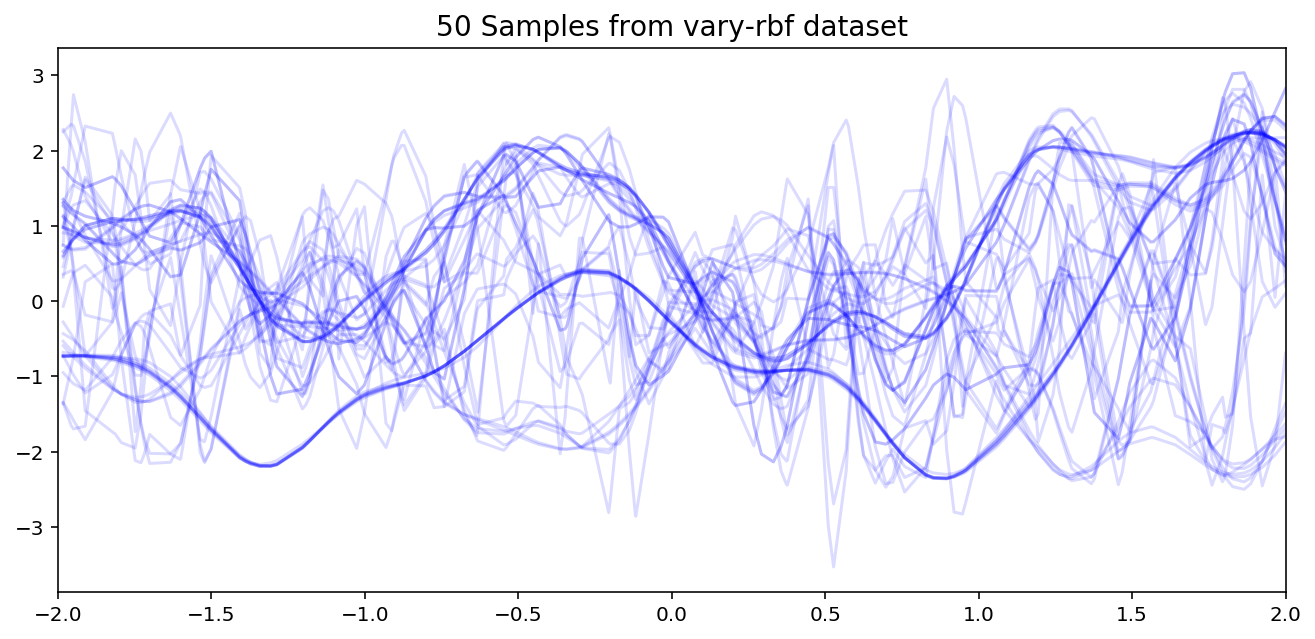

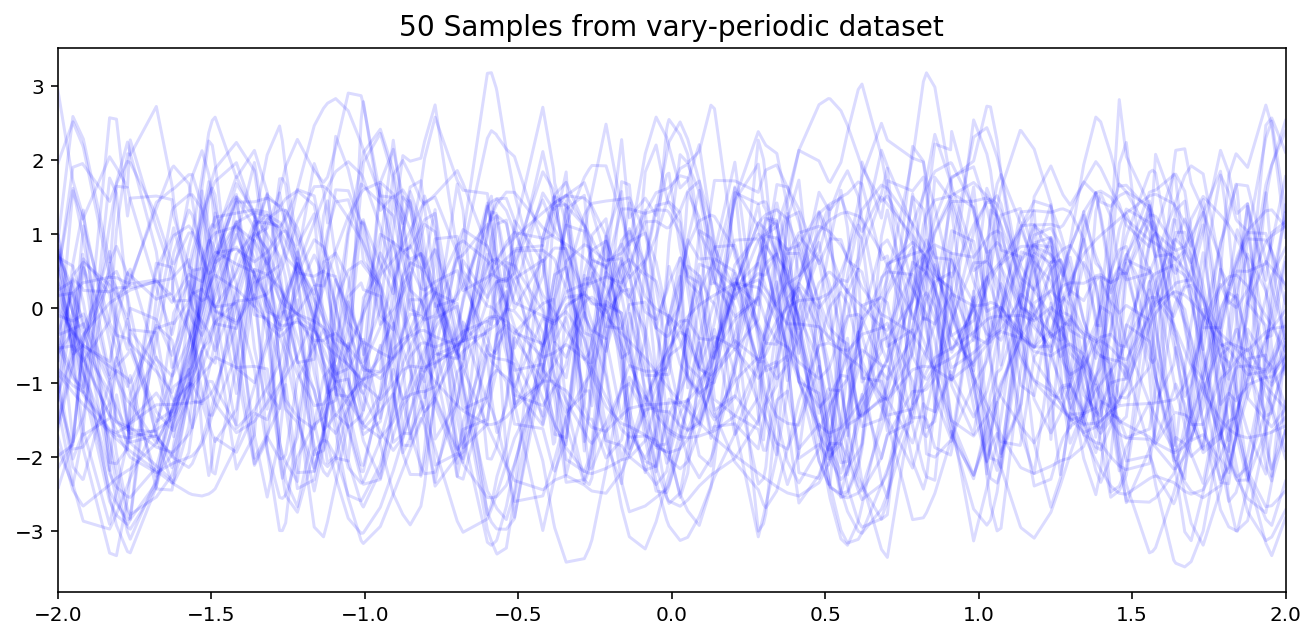

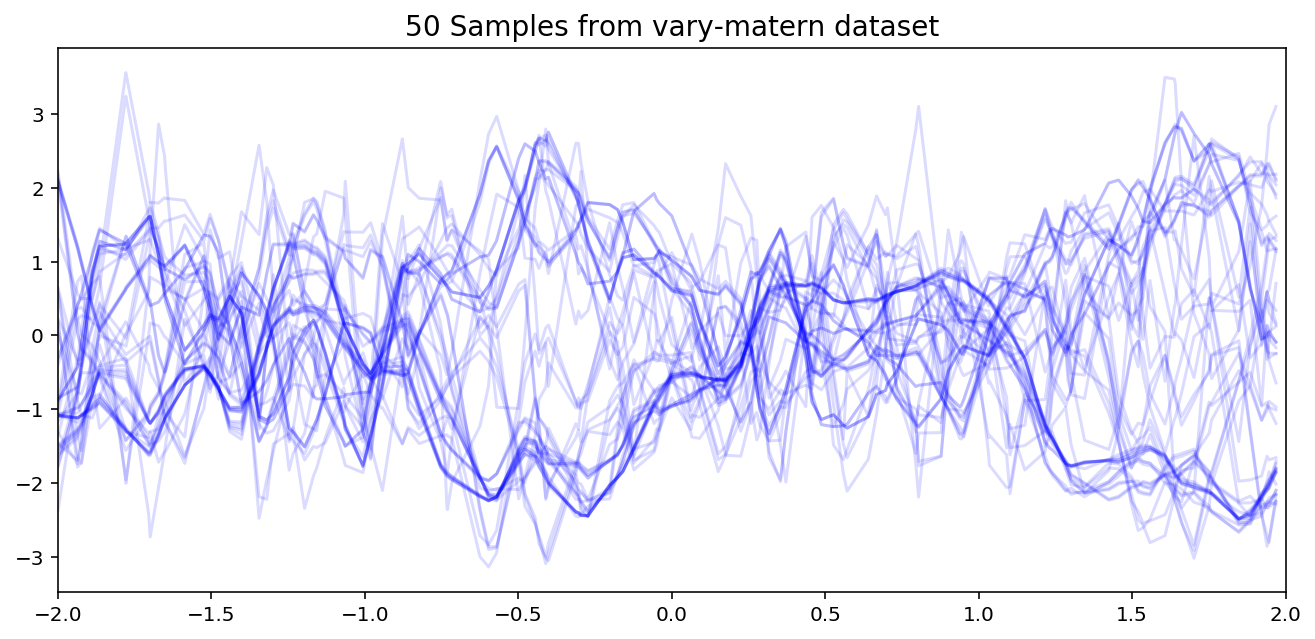

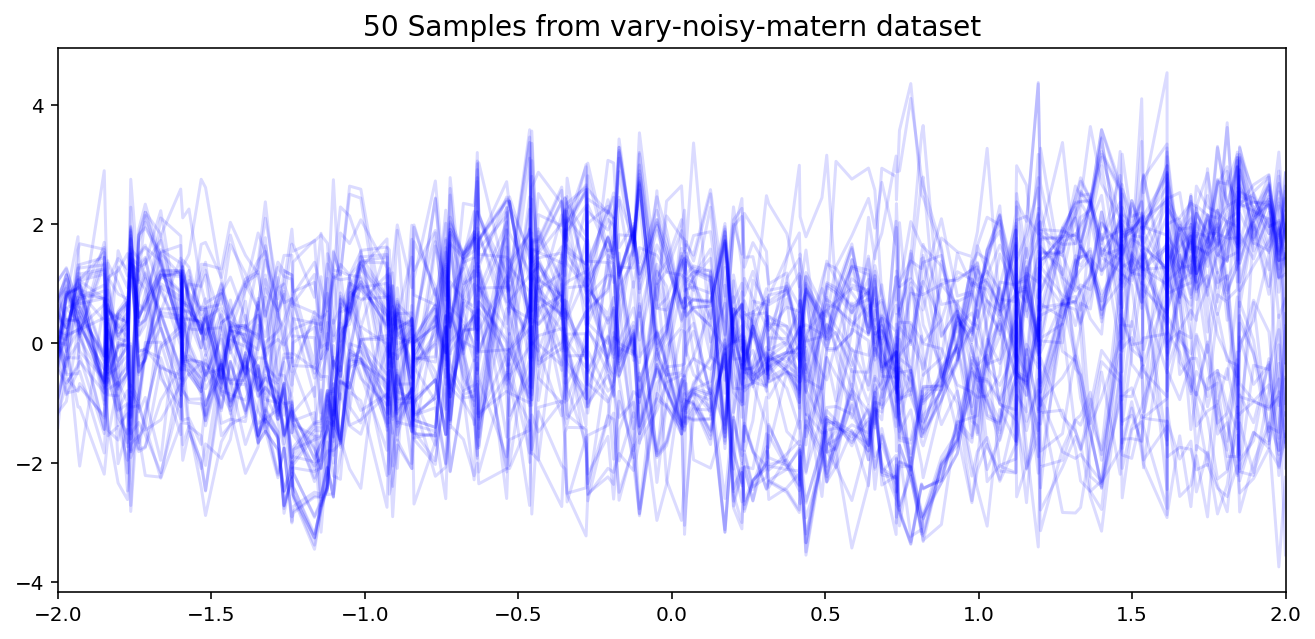

In [17]:
for k,v in datasets.items():
    plot_dataset_samples(v, title='50 Samples from {} dataset'.format(k), n_samples=50)

## Models Loading


In [18]:
import torch.nn as nn
from neuralproc import GlobalNeuralProcess, discard_ith_arg, AttentiveNeuralProcess
from neuralproc.utils.helpers import change_param, rescale_range
from neuralproc.utils.datasplit import get_all_indcs, CntxtTrgtGetter, GetRandomIndcs, GetRangeIndcs, GetIndcsMerger
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP
from neuralproc.utils.setcnn import SetConv,MlpRBF, GaussianRBF
from neuralproc.encoders import SinusoidalEncodings
from utils.helpers import count_parameters
from ntbks_helpers import train_all_models_, get_percentile_converge_epoch, CNP_KWARGS

get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=.5),
                                 targets_getter=GetRandomIndcs(min_n_indcs=0.5, max_n_indcs=0.99),
                                 is_add_cntxts_to_trgts=False)  # don't context points to tagrtes

In [19]:
loaded = dict()

### Extended GNP Simple

In [ ]:
model_name = "extended_gnp_simple"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, RadialBasisFunc=MlpRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=True,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1709Mb")

    
run = 4
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=True) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Extended GNP Unet

In [9]:
model_name = "extended_gnp_unet" 

gnp_kwargs = dict(r_dim=8,
                  keys_to_tmp_attn=change_param(SetConv, RadialBasisFunc=MlpRBF),
                  TmpSelfAttn=change_param(UnetCNN,
                                           Conv=torch.nn.Conv1d,
                                           Pool=torch.nn.MaxPool1d,
                                           upsample_mode="linear",
                                           n_layers=10,
                                           is_double_conv=True,
                                           bottleneck=None,
                                           is_depth_separable=True,
                                           Normalization=torch.nn.BatchNorm1d,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1021Mb")
   
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

/master/neuralproc/predefined/mlp.py:61: UserWarning: hidden_size=32 larger than output=8 and input=1. Setting it to 8.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/neuralproc/predefined/mlp.py:61: UserWarning: hidden_size=32 larger than output=2 and input=8. Setting it to 8.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


N Param: 8952
Memory: 1021Mb

--- Loading rbf ---


--- Loading periodic ---


--- Loading matern ---


--- Loading noisy-matern ---


--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended GNP Simple Only MLP

In [10]:
model_name = "extended_gnp_simple_only_mlp"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, is_vanilla=True,
                                                RadialBasisFunc=MlpRBF),  # onyl diff with vanilla
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=False,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, is_vanilla=True,
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 3237Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

N Param: 28660
Memory: 3237Mb

--- Loading rbf ---


--- Loading periodic ---


--- Loading matern ---


--- Loading noisy-matern ---


--- Loading vary-rbf ---


--- Loading vary-periodic ---


--- Loading vary-matern ---


--- Loading vary-noisy-matern ---



### Extended GNP Simple Only Normalize

In [ ]:
model_name = "extended_gnp_simple_only_normalize"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv,
                                                is_vanilla=False,  # onyl diff with vanilla
                                                RadialBasisFunc=GaussianRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=False,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv,
                                                   is_vanilla=False,  # onyl diff with vanilla
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 2677Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Extended GNP Simple Only Depth Separable

In [ ]:
model_name = "extended_gnp_simple_only_depthsep"

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, is_vanilla=True,
                                                RadialBasisFunc=GaussianRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=True, # onyl diff with vanilla
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, is_vanilla=True,
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 2691Mb")

    
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Extended ANP Sin

In [ ]:
model_name = "extended_anp_sin"  

ANP_KWARGS = dict(get_cntxt_trgt=get_cntxt_trgt,
                  r_dim=32,
                  encoded_path="deterministic",  # use CNP
                  attention="weighted_dist",
                  XEncoder=SinusoidalEncodings,
                  is_relative_pos=False)

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **ANP_KWARGS), data)
               for name, data in datasets.items()}

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1103Mb") # mostly large due to the relative positions


  
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Extended ANP Rel

In [ ]:
model_name = "extended_anp_rel"  

ANP_KWARGS = dict(get_cntxt_trgt=get_cntxt_trgt,
                  r_dim=32,
                  encoded_path="deterministic", # use CNP
                  attention="multihead",
                  is_relative_pos=True) 

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **ANP_KWARGS), data)
               for name, data in datasets.items()}

for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 1301Mb") # mostly large due to the relative positions
  
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Baseline

In [ ]:
model_name = "baseline_rbf"   

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, 
                                                RadialBasisFunc=change_param(GaussianRBF, 
                                                                             max_dist_weight=0.7)),
                  TmpSelfAttn=None,
                  tmp_to_queries_attn=torch.nn.Identity,
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 629Mb")
     
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Vanilla ANP

In [ ]:
model_name = "vanilla_anp"   

anp_kwargs = dict(r_dim=32,
                  get_cntxt_trgt=get_cntxt_trgt,
                  encoded_path="deterministic",
                  attention="multihead",
                  is_relative_pos=False)

# initialize one model for each dataset
data_models = {name: (AttentiveNeuralProcess(X_DIM, Y_DIM, **anp_kwargs), data)
               for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 747Mb")
 
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

### Vanilla GNP

In [ ]:
model_name = "vanilla_gnp" 

gnp_kwargs = dict(r_dim=32,
                  keys_to_tmp_attn=change_param(SetConv, is_vanilla=True,
                                                RadialBasisFunc=GaussianRBF),
                  TmpSelfAttn=change_param(CNN,
                                           Conv=torch.nn.Conv1d,
                                           n_layers=3,
                                           is_depth_separable=False,
                                           Normalization=torch.nn.Identity,
                                           is_chan_last=True,
                                           kernel_size=11),
                  tmp_to_queries_attn=change_param(SetConv, is_vanilla=True,
                                                   RadialBasisFunc=GaussianRBF),
                  is_skip_tmp=False,
                  is_use_x=False,
                  get_cntxt_trgt=get_cntxt_trgt,
                  is_encode_xy=False)

# initialize one model for each dataset
data_models = {name: (GlobalNeuralProcess(X_DIM, Y_DIM, **gnp_kwargs), data) 
                   for name, data in datasets.items()}

# PARAM
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break
    
# MEMORY:
print("Memory: 3403Mb")
   
run = 0
trainers = train_all_models_(data_models, 
                            "results/attn_conv_compare/data_1D/run_k{}/{}".format(run, model_name),
                             is_retrain=False) # if false load precomputed

loaded[model_name] = dict(data_models=data_models, trainers=trainers)

## Evaluation

### Quantitative

In [14]:
def score_cnp(trainer, dataset, batch_size=512, n_test=100000, is_set_eval=True, **kwargs):
    """Return the log likelihood"""
    score = 0
    n_steps = 0
    
    # when evealuating loss, use all targtes in that are not in context (but still sampel context)
    trainer.module_.get_cntxt_trgt.set_eval()
        
    # use th eloss as metric (i.e. return log likelihood)
    trainer.criterion_.is_use_as_metric = True
    
    X_test, y_test = dataset.get_samples(n_samples=n_test, **kwargs)
    for i in range(0, n_test, batch_size):
        Xi, yi = X_test[i:i+batch_size], y_test[i:i+batch_size]
        # puts in a skorch format (because y is splitted in the module itself)
        step = trainer.validation_step({"X":Xi, "y":yi}, yi)
        score += step["loss"].item()
        n_steps += 1
        break
        
    score /= n_steps
    
    trainer.module_.get_cntxt_trgt.reset() # reset in case used in future
    
    return score 

In [15]:
def score_cnp_extrap(trainer, dataset, extrap_mode, extrap_distance=4, **kwargs):
    """Return the log likelihood of extrapolation."""
    interpolation_range = dataset.min_max
    extrapolation_range = (dataset.min_max[0], dataset.min_max[1] + extrap_distance)    

    extrap_rescaled_range = tuple(rescale_range(np.array(extrapolation_range), interpolation_range, (-1,1)))
    trainer.module_.set_extrapolation(extrap_rescaled_range) # set the model in extrapolation mode
    
    train_n_points = dataset.n_points
    total_n_points = int(rescale_range(dataset.n_points, interpolation_range, extrapolation_range))
    
    if extrap_mode == "shift":
        # shifting both the targets and context equally
        targets_getter = GetRangeIndcs((train_n_points, total_n_points))
        contexts_getter = GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5,
                                         range_indcs=(train_n_points, total_n_points))
        
    elif extrap_mode == "scale":
        # adding more context (making sure that keeping correct density for comparaison)
        contexts_getter = GetIndcsMerger([GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5, 
                                                         range_indcs=(0, train_n_points)),
                                          GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=0.5, 
                                                         range_indcs=(train_n_points, total_n_points))])
        targets_getter = GetRangeIndcs((0, train_n_points))
        
        
    elif extrap_mode == "future":
        # predicting in the future => keeping same context but shifting targt
        contexts_getter = GetRandomIndcs(min_n_indcs=0.01, max_n_indcs=.5, range_indcs=(0, train_n_points))
        targets_getter = GetRangeIndcs((train_n_points, total_n_points))
        
    else:
        raise ValueError("Unkown extrap_mode = {}.".format(extrap_mode))
        
    trainer.module_.get_cntxt_trgt.tmp_args["targets_getter"] = targets_getter
    trainer.module_.get_cntxt_trgt.tmp_args["contexts_getter"] = contexts_getter
    
    score = score_cnp(trainer, dataset, n_points=total_n_points, test_min_max=extrapolation_range, 
                      save_file**kwargs)
    
    trainer.module_.set_extrapolation(interpolation_range) # put back to normal
    
    return score

In [ ]:
def score_cnp_dense(trainer, dataset, **kwargs):
    """Return the log likelihood when increasing density."""
    
    # making sure that have high density by taking large context
    trainer.module_.get_cntxt_trgt.tmp_args["contexts_getter"] = GetRandomIndcs(min_n_indcs=.3, max_n_indcs=.7)
    
    # increase density by 100 and decrease test number by 10 (if not time ++), also decrease batchsize
    # for memory reasons
    score = score_cnp(trainer, dataset, n_points=dataset.n_points * 10, n_test=50000, batch_size=32, **kwargs)
    
    return score

In [72]:
import json

def make_all_summaries(loaded, save_file=None):
    """Return a dictionary of summaries: group -> data -> summary."""
    all_summaries = dict()
    for i, (model_name, loaded_group) in enumerate(loaded.items()):
        print()
        print("--- {} ---".format(model_name))
        all_summaries[model_name] = dict()
        for data_name, trainer in loaded_group["trainers"].items():
            print(data_name)
            history = trainer.history
            dataset = loaded_group["data_models"][data_name][1]
            
            converged_epoch = len(history)
            train_log_likelihood = - history[-1]["train_loss"]
            train_losses = [h['train_loss'] for h in history]
            percentile_converged_epoch = get_percentile_converge_epoch(history, percentile=0.1)
            time_per_epochs=sum(h['dur'] for h in history)/len(history)
            
            test_log_likelihood_interp = score_cnp(trainer, dataset, 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_interp"))
            test_log_likelihood_future = score_cnp_extrap(trainer, dataset, "future", 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_extrap"))
            test_log_likelihood_scale = score_cnp_extrap(trainer, dataset, "scale", 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_extrap"))
            test_log_likelihood_shift = score_cnp_extrap(trainer, dataset, "shift", 
                                                   save_file=("data/gp_dataset.hdf5", "{}/test_extrap")) 
            
            try :
                test_log_likelihood_dense = score_cnp_dense(trainer, dataset, 
                                                            save_file=("data/gp_dataset.hdf5", "{}/test_dense"))
            except:
                print("issue with dense for", data_name)
                test_log_likelihood_dense = float("inf")
                
            all_summaries[model_name][data_name] = dict(converged_epoch = converged_epoch,
                                                       train_log_likelihood = train_log_likelihood,
                                                       percentile_converged_epoch = percentile_converged_epoch,
                                                       time_per_epochs = time_per_epochs,
                                                       test_log_likelihood_interp = test_log_likelihood_interp,
                                                       test_log_likelihood_future = test_log_likelihood_future,
                                                       test_log_likelihood_scale=test_log_likelihood_scale,
                                                        test_log_likelihood_shift=test_log_likelihood_shift,
                                                        test_log_likelihood_dense = test_log_likelihood_dense,
                                                       train_losses=train_losses) 
            
    
            if i==0:
                all_summaries["Gaussian Process"][data_name] = None
                print("ADD GP")
            
    if save_file is not None:
        if os.path.exists(save_file):
            os.rename(save_file, save_file+".bak")
            
        with open(save_file,"w") as f:
            json.dump(all_summaries, f)
        
    return all_summaries

In [73]:
%%time
all_summaries = make_all_summaries(loaded, save_file="results/attn_conv_compare/summaries.json")


--- extended_gnp_small ---
rbf
periodic
matern
noisy-matern
vary-rbf
vary-periodic
vary-matern
vary-noisy-matern

--- extended_gnp_large ---
rbf
periodic
matern
noisy-matern
vary-rbf
vary-periodic
vary-matern
vary-noisy-matern

--- extended_anp_small ---
rbf
periodic
matern
noisy-matern
vary-noisy-matern

--- baseline_kernel_reg ---
rbf
periodic
matern
noisy-matern
vary-rbf
vary-periodic
vary-matern
vary-noisy-matern

--- vanilla_anp ---
rbf
periodic
matern
noisy-matern
vary-rbf
vary-periodic
vary-matern
vary-noisy-matern

--- vanilla_gnp ---
rbf
periodic
matern
noisy-matern
vary-rbf
vary-periodic
vary-matern
vary-noisy-matern
CPU times: user 2h 1min 59s, sys: 13min 35s, total: 2h 15min 34s
Wall time: 19min 41s


In [77]:
for group, summaries in all_summaries.items():
    print()
    print(group)
    for data, s in summaries.items():
        print("  ", data)
        for k,v in s.items():
            if k == 'train_losses':
                continue
            print("    ", k, ":", v)


extended_gnp_small
   rbf
     converged_epoch : 34
     train_log_likelihood : 0.7531415236842632
     percentile_converged_epoch : 11
     time_per_epochs : 112.5781115363626
     test_log_likelihood_interp : 1.3028150796890259
     test_log_likelihood_future : -1.908797264099121
     test_log_likelihood_scale : -0.488641619682312
     test_log_likelihood_shift : 1.2602720260620117
     test_log_likelihood_dense : 0.8911340832710266
   periodic
     converged_epoch : 30
     train_log_likelihood : -1.2923081452178955
     percentile_converged_epoch : 13
     time_per_epochs : 112.39223722616832
     test_log_likelihood_interp : -1.2816003561019897
     test_log_likelihood_future : -1.3061448335647583
     test_log_likelihood_scale : -1.2945207357406616
     test_log_likelihood_shift : -1.3099544048309326
     test_log_likelihood_dense : -1.262820839881897
   matern
     converged_epoch : 43
     train_log_likelihood : 0.31132153573632243
     percentile_converged_epoch : 21
     tim

     converged_epoch : 33
     train_log_likelihood : 0.7277288943123817
     percentile_converged_epoch : 13
     time_per_epochs : 111.8679691661488
     test_log_likelihood_interp : 1.1077326536178589
     test_log_likelihood_future : -1.3240915536880493
     test_log_likelihood_scale : -0.08962234854698181
     test_log_likelihood_shift : -0.8889102339744568
     test_log_likelihood_dense : 0.31857985258102417
   periodic
     converged_epoch : 43
     train_log_likelihood : -1.2922516947937013
     percentile_converged_epoch : 2
     time_per_epochs : 111.83415392942207
     test_log_likelihood_interp : -1.4704118967056274
     test_log_likelihood_future : -1.3096249103546143
     test_log_likelihood_scale : -1.4605194330215454
     test_log_likelihood_shift : -1.2936718463897705
     test_log_likelihood_dense : -1.2712996006011963
   matern
     converged_epoch : 42
     train_log_likelihood : 0.3128130524581671
     percentile_converged_epoch : 16
     time_per_epochs : 111.9779

### Qualitative

In [17]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

In [18]:
for model_name, loaded_group in loaded.items():
    for k,(neural_proc, dataset) in loaded_group['data_models'].items():
        extrap_rescaled_range = tuple(rescale_range(np.array(EXTRAPOLATION_RANGE), (-2,2), (-1,1)))
        neural_proc.set_extrapolation(extrap_rescaled_range)

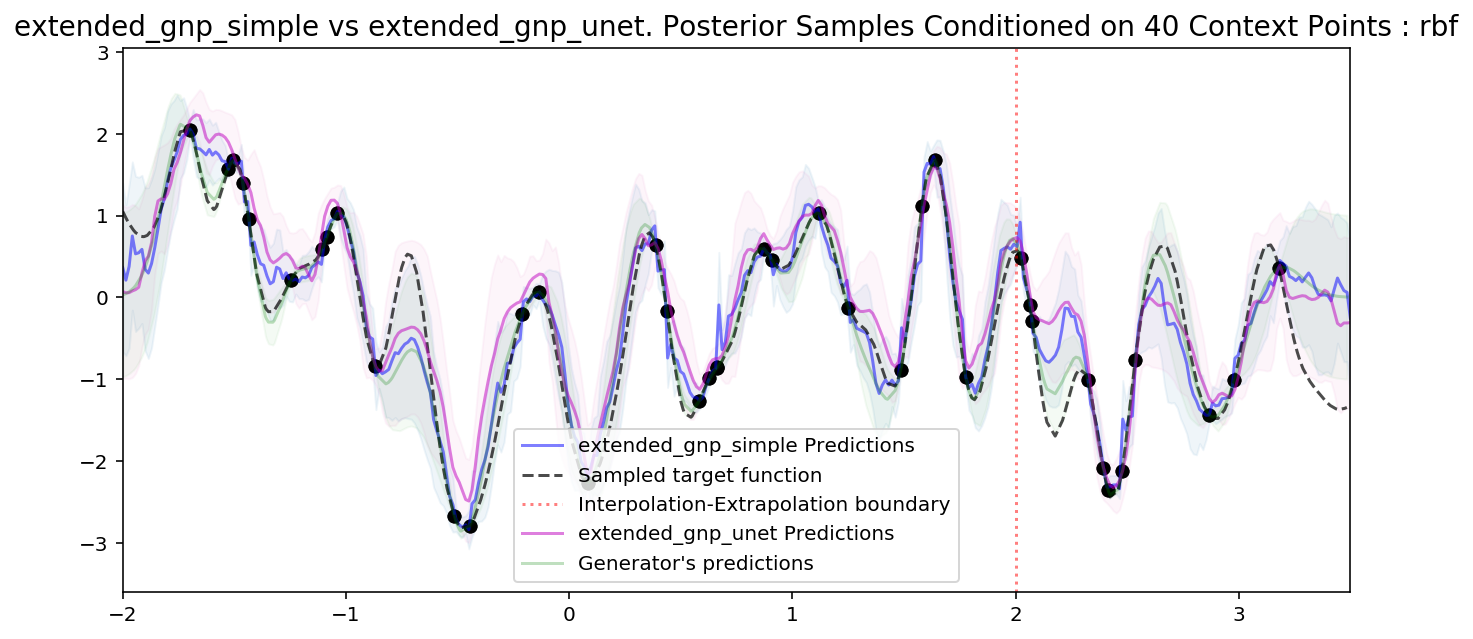

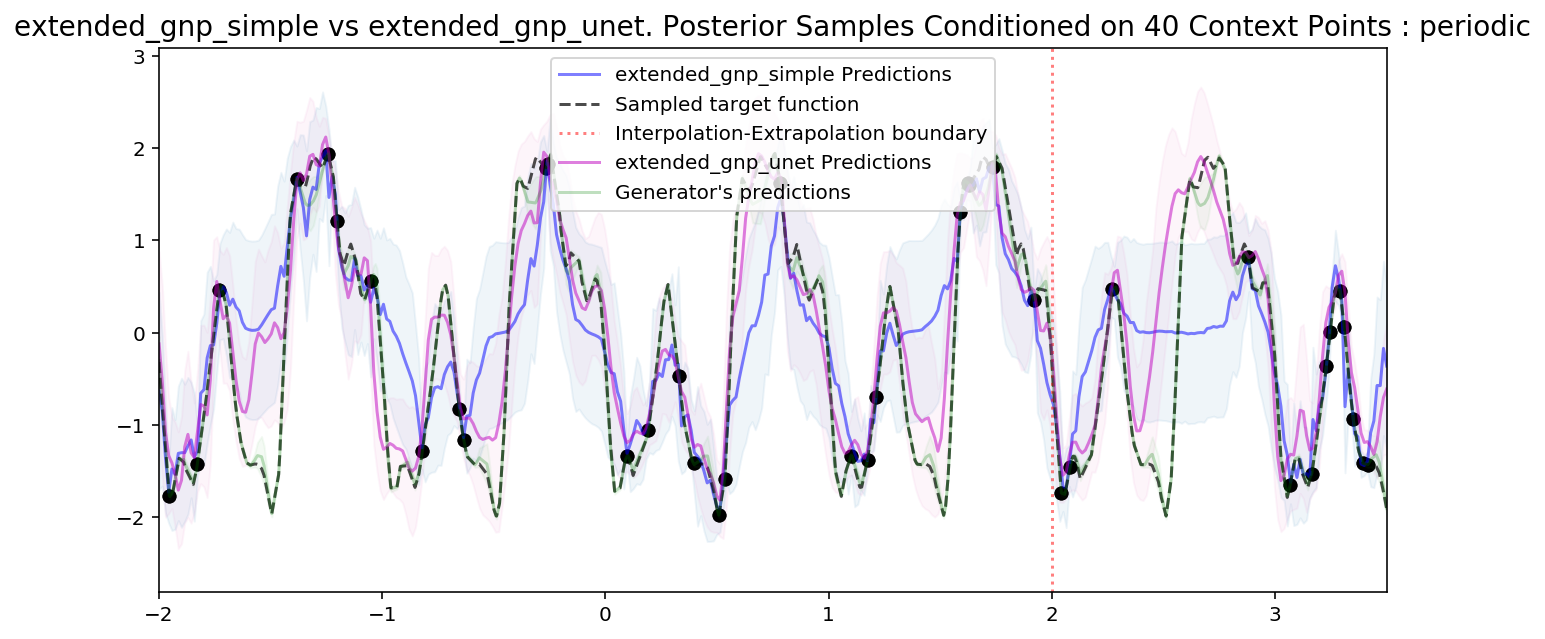

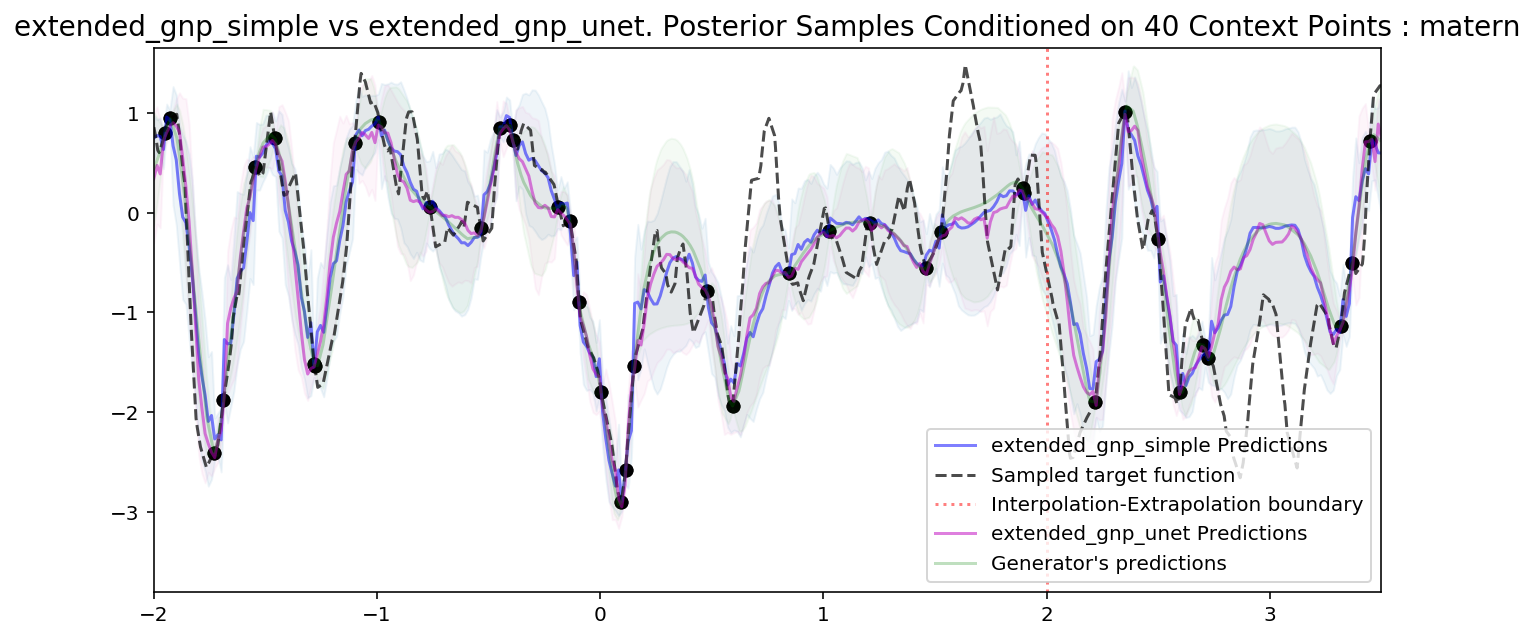

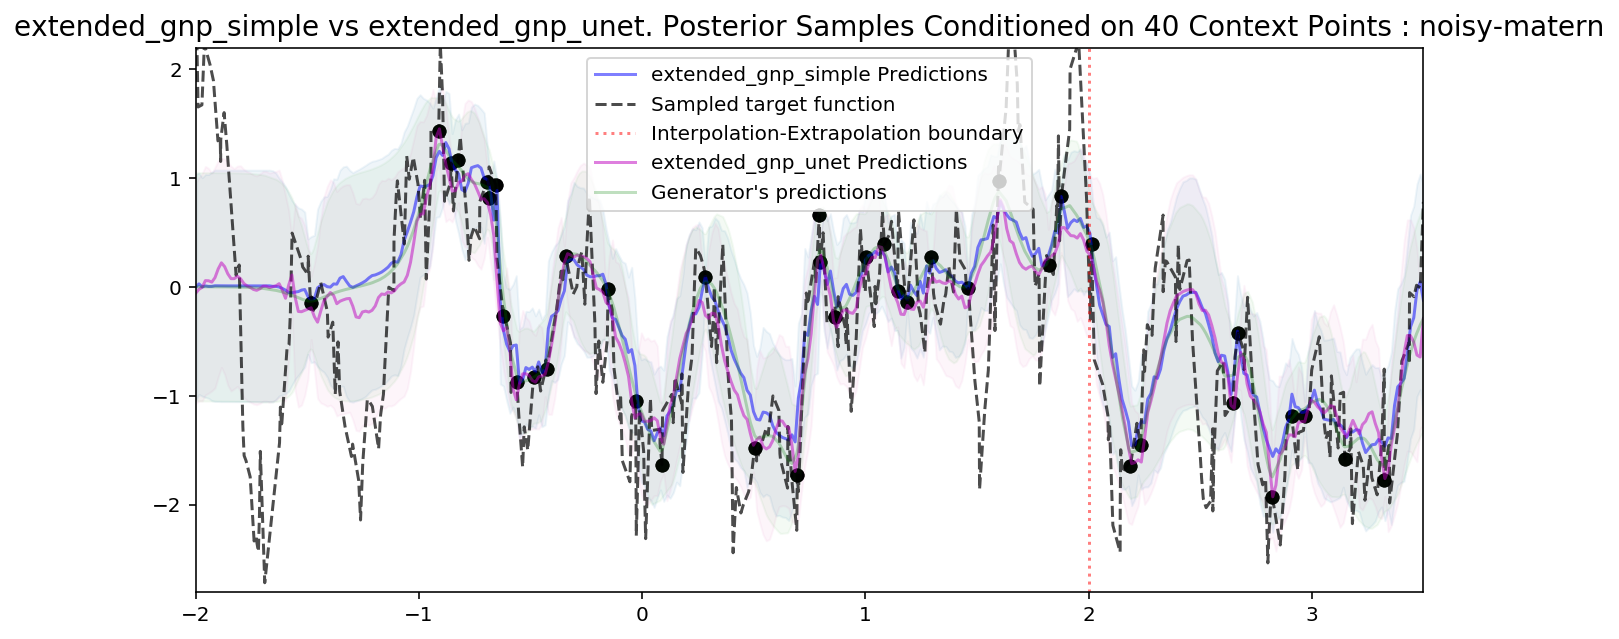

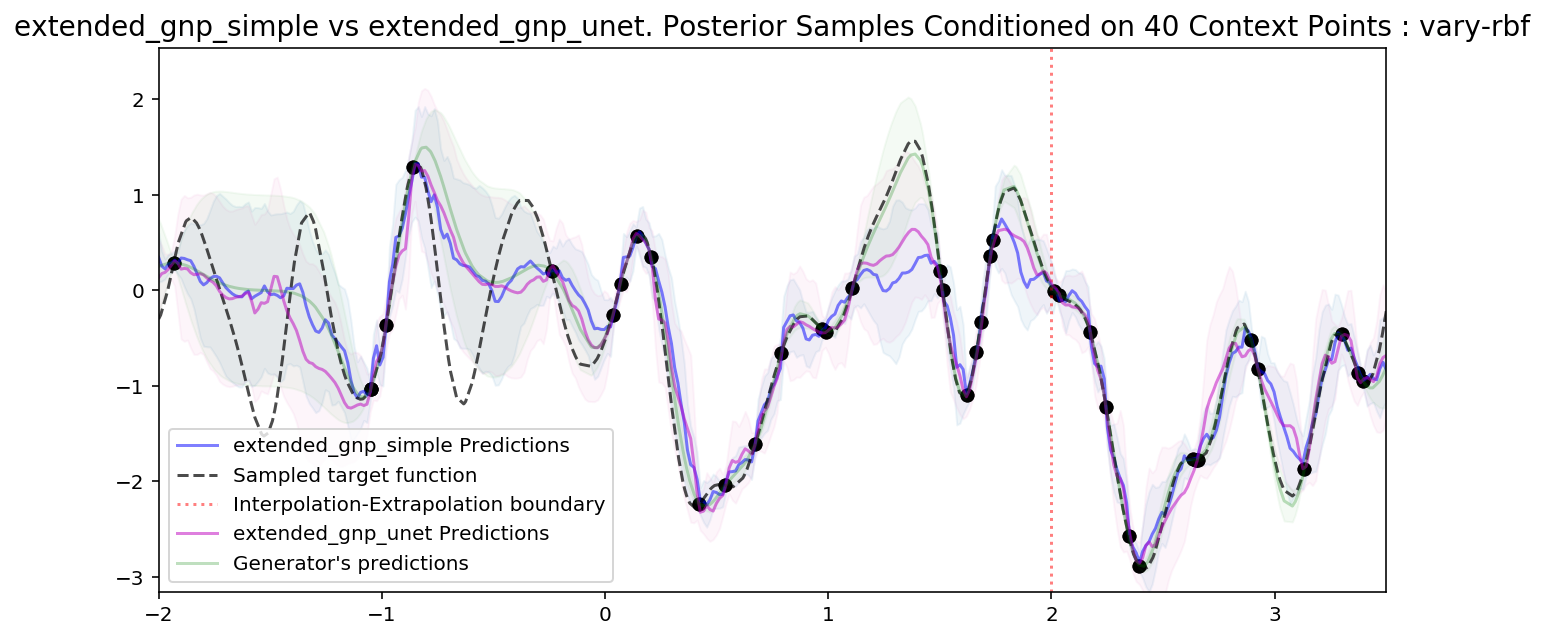

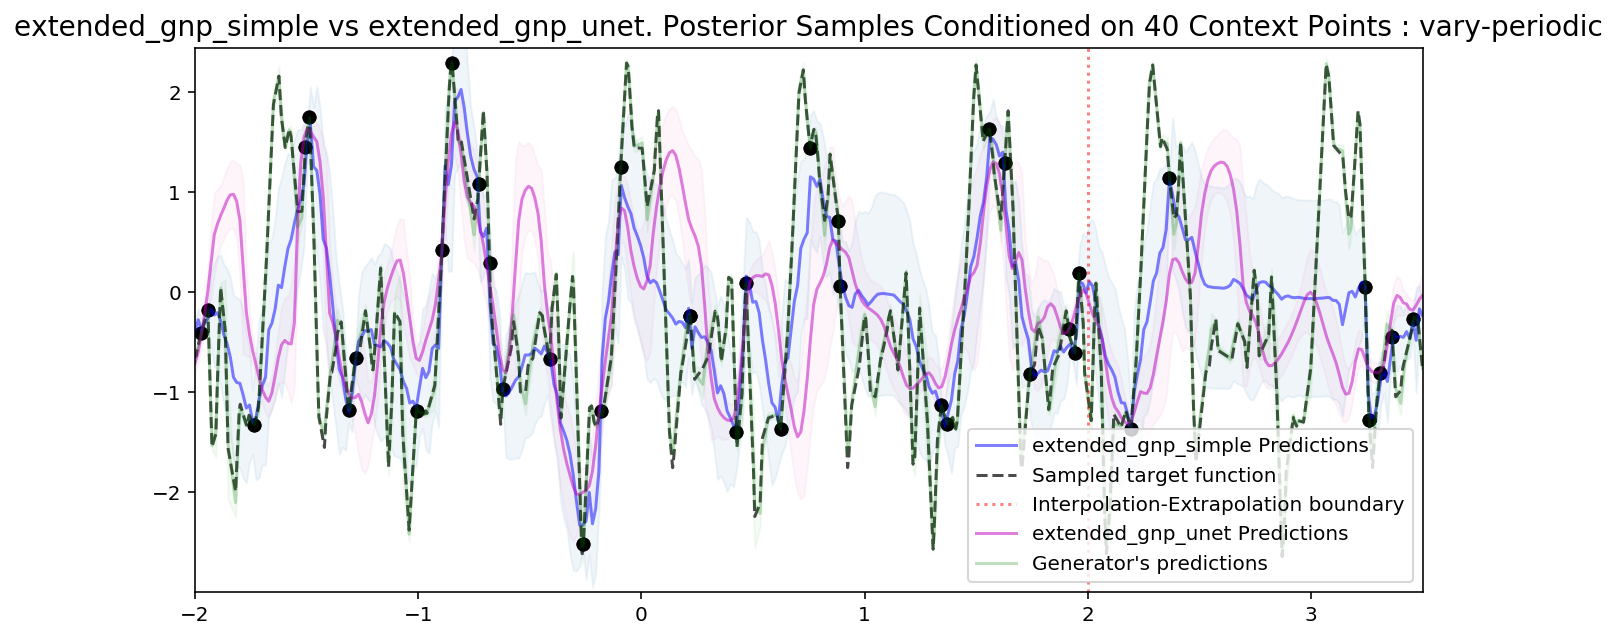

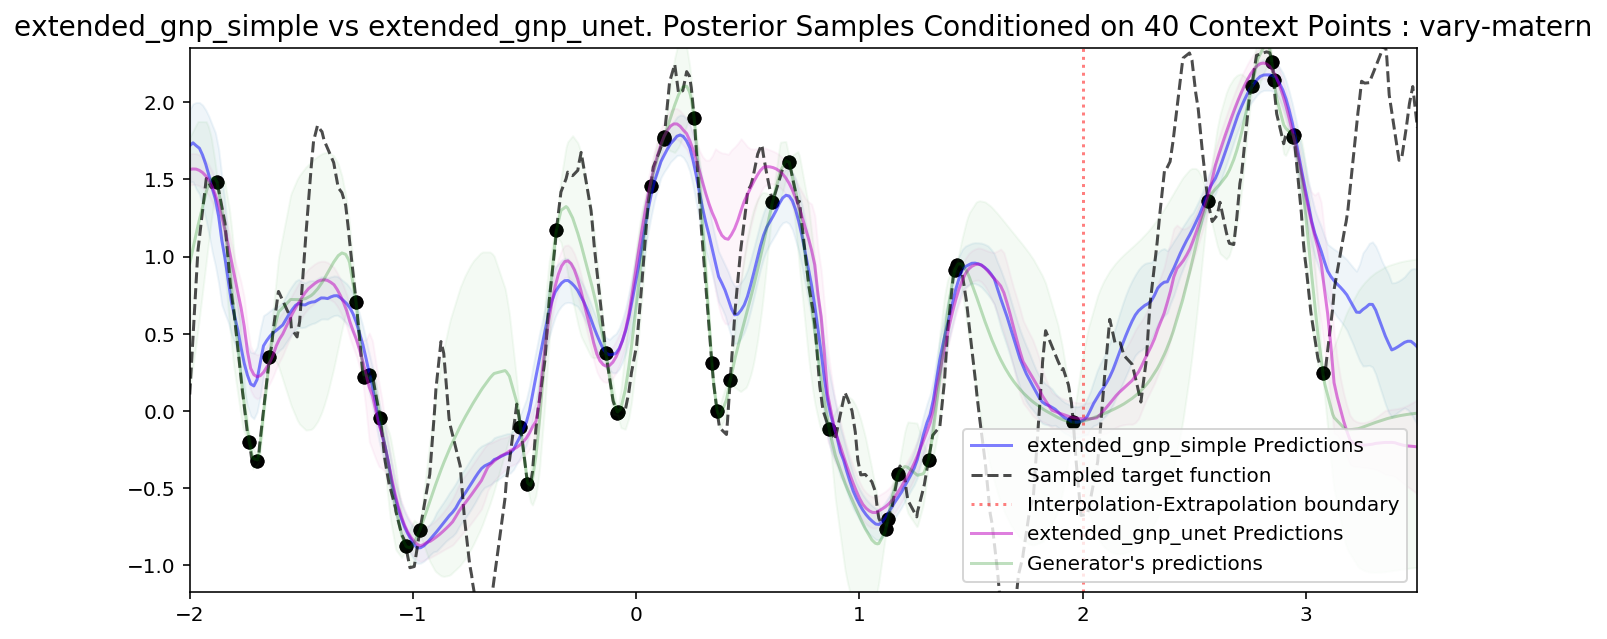

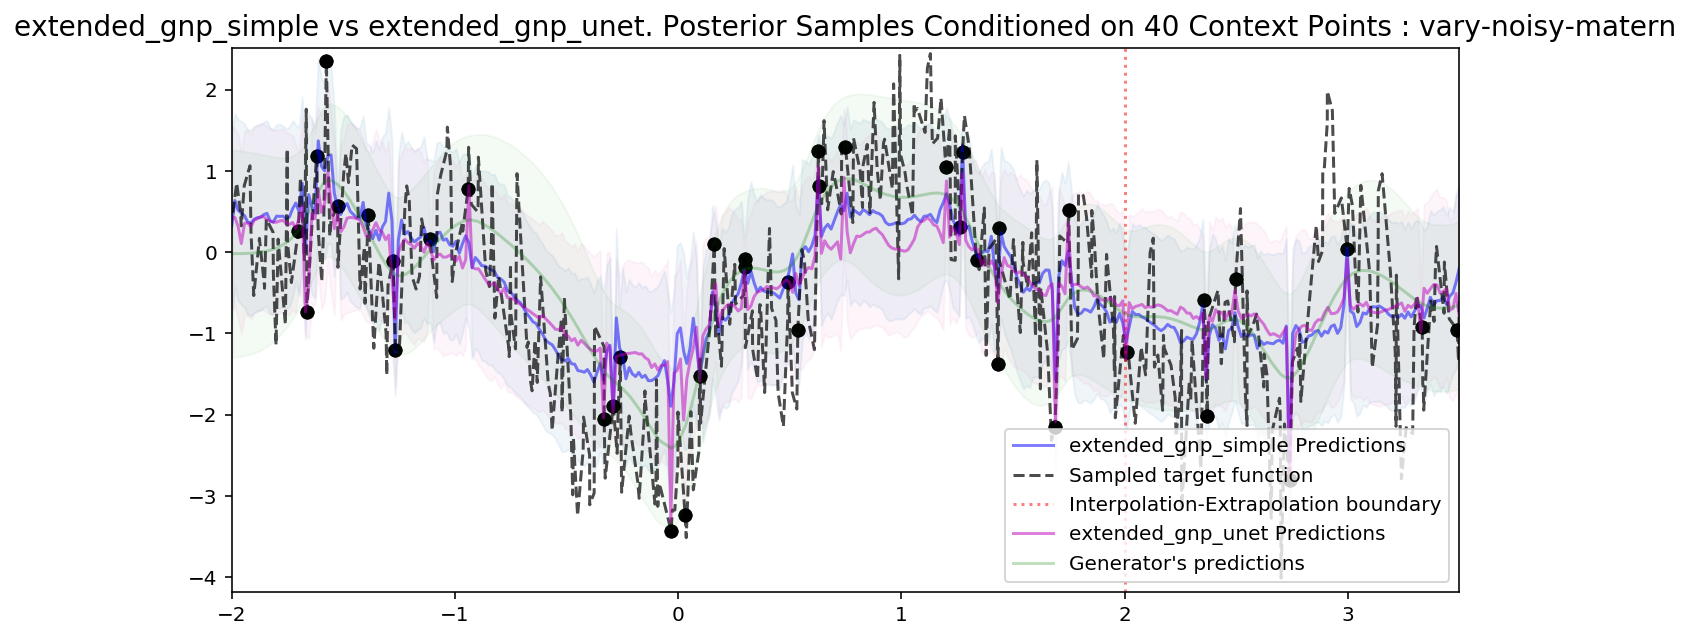

In [20]:
N_CNTXT = 40

model1 = 'extended_gnp_simple'
model2 = 'extended_gnp_unet'

for k,(neural_proc, dataset) in loaded[model1]['data_models'].items():
    
    plot_posterior_samples(dataset, neural_proc, 
                           compare_model=loaded[model2]['data_models'][k][0],
                           model_labels=[model1, model2],
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="{} vs {}. Posterior Samples Conditioned on {} Context Points : {}".format(model1, model2, N_CNTXT, k))

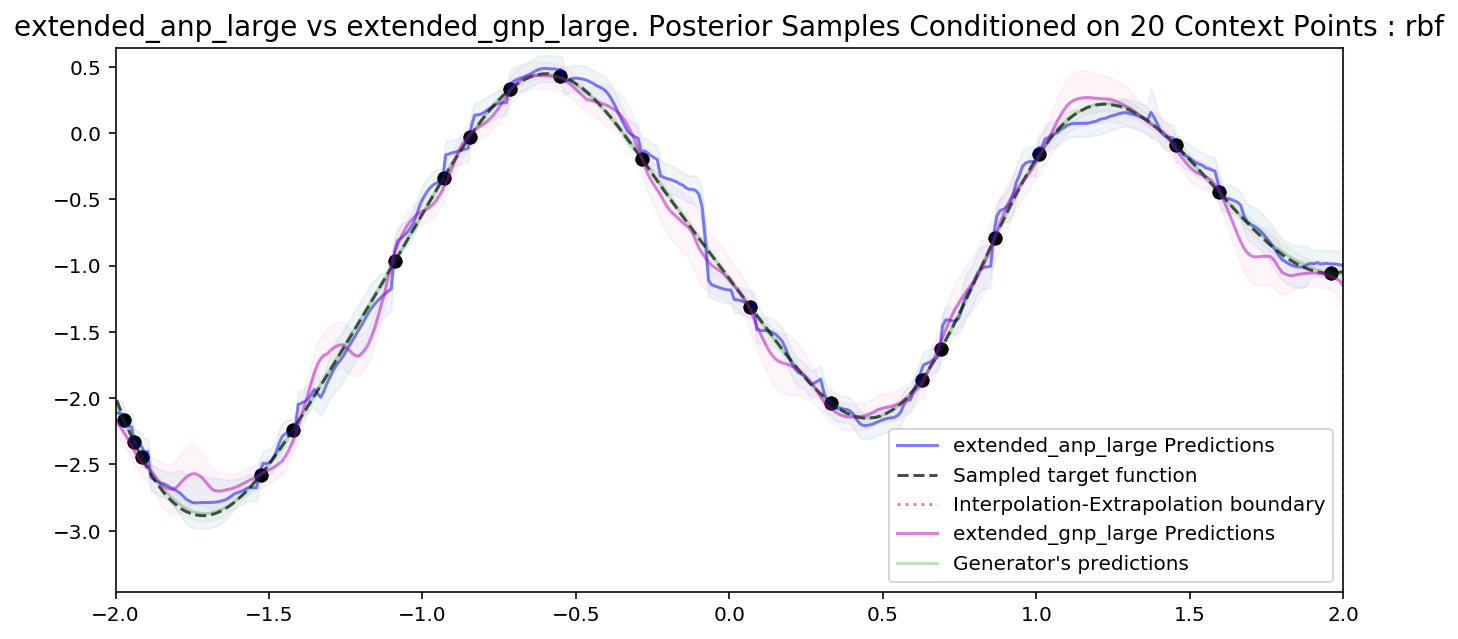

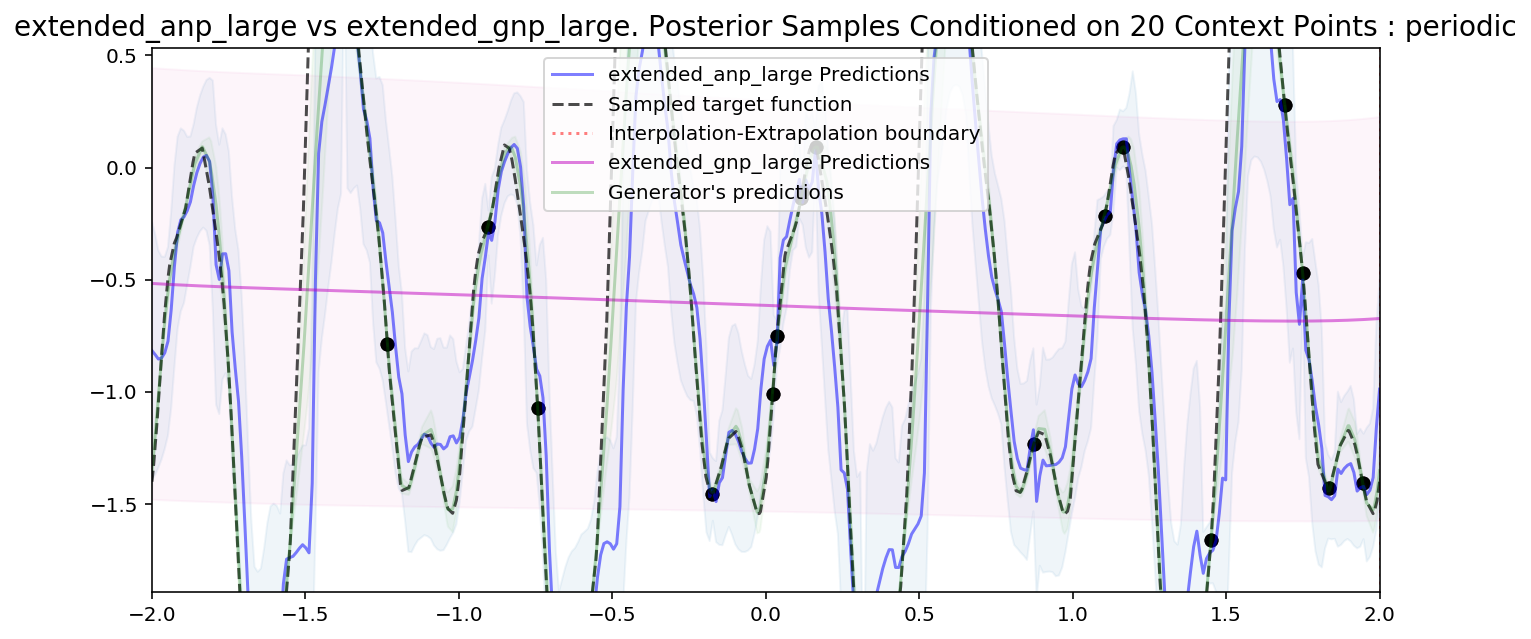

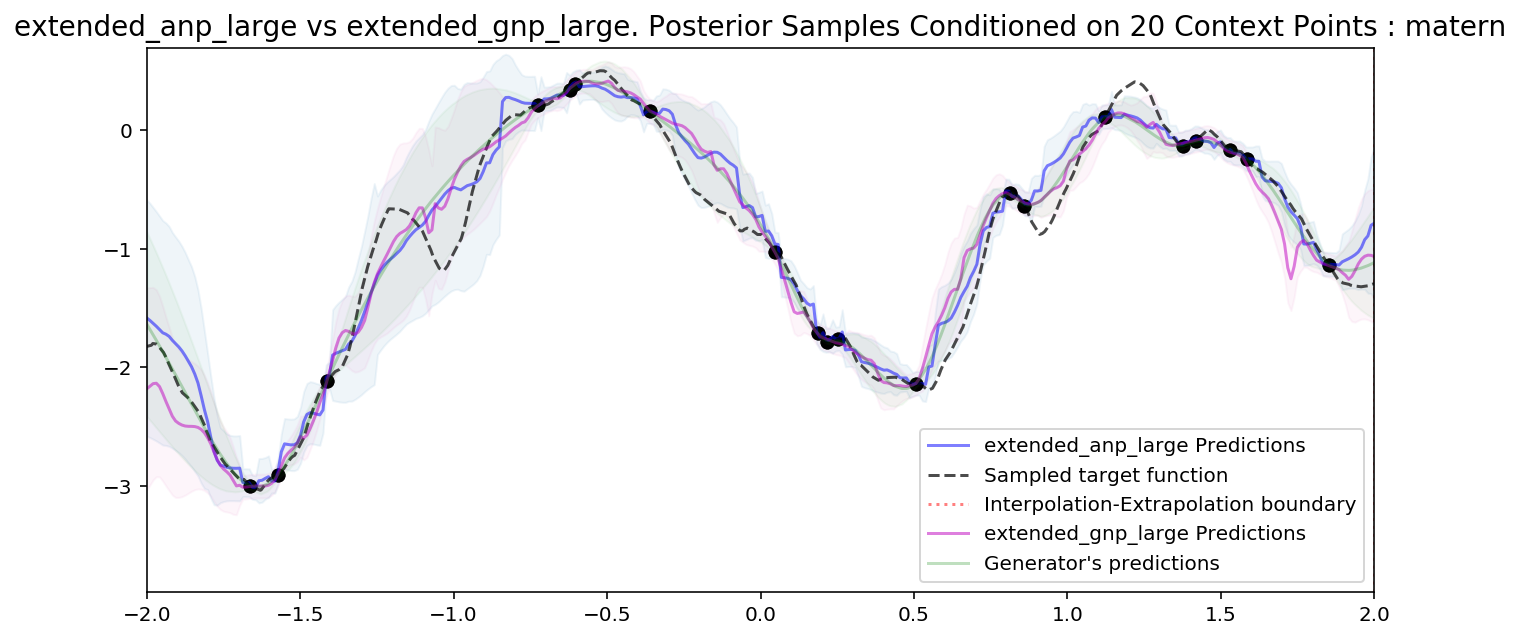

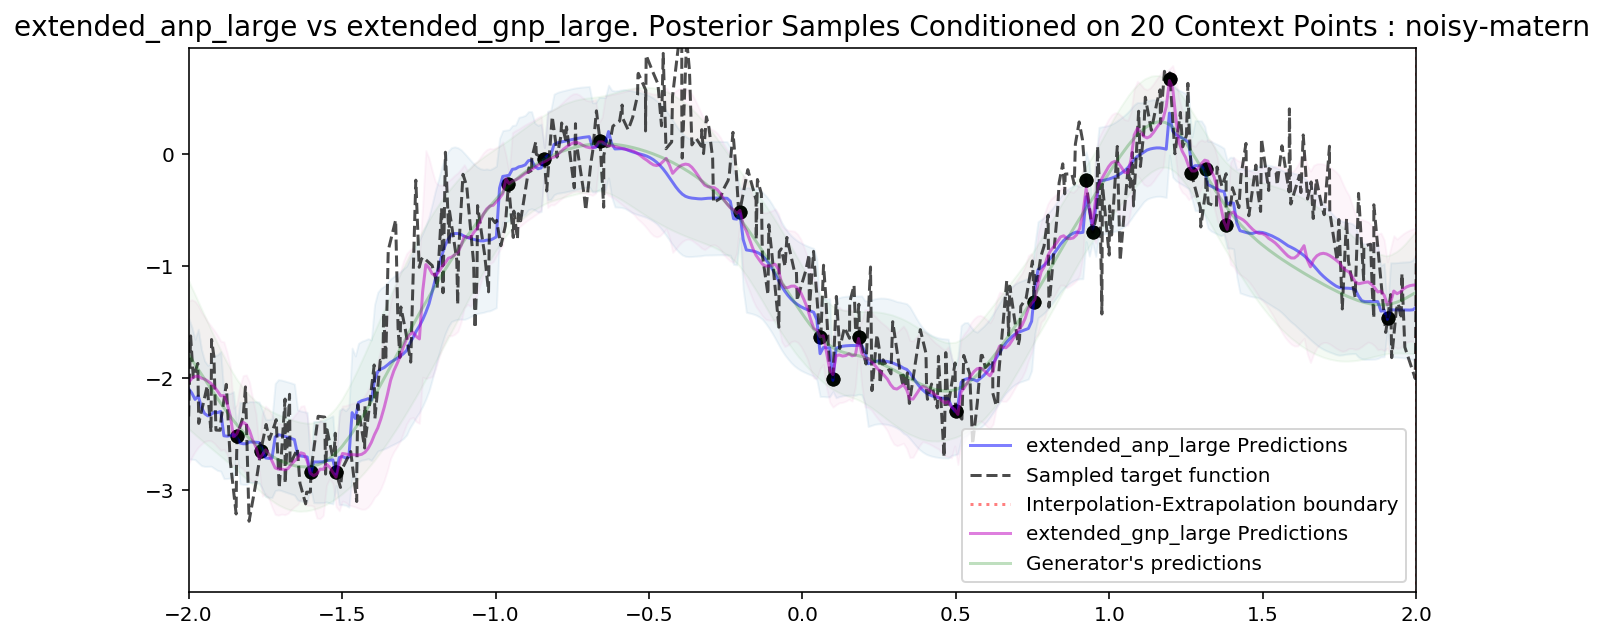

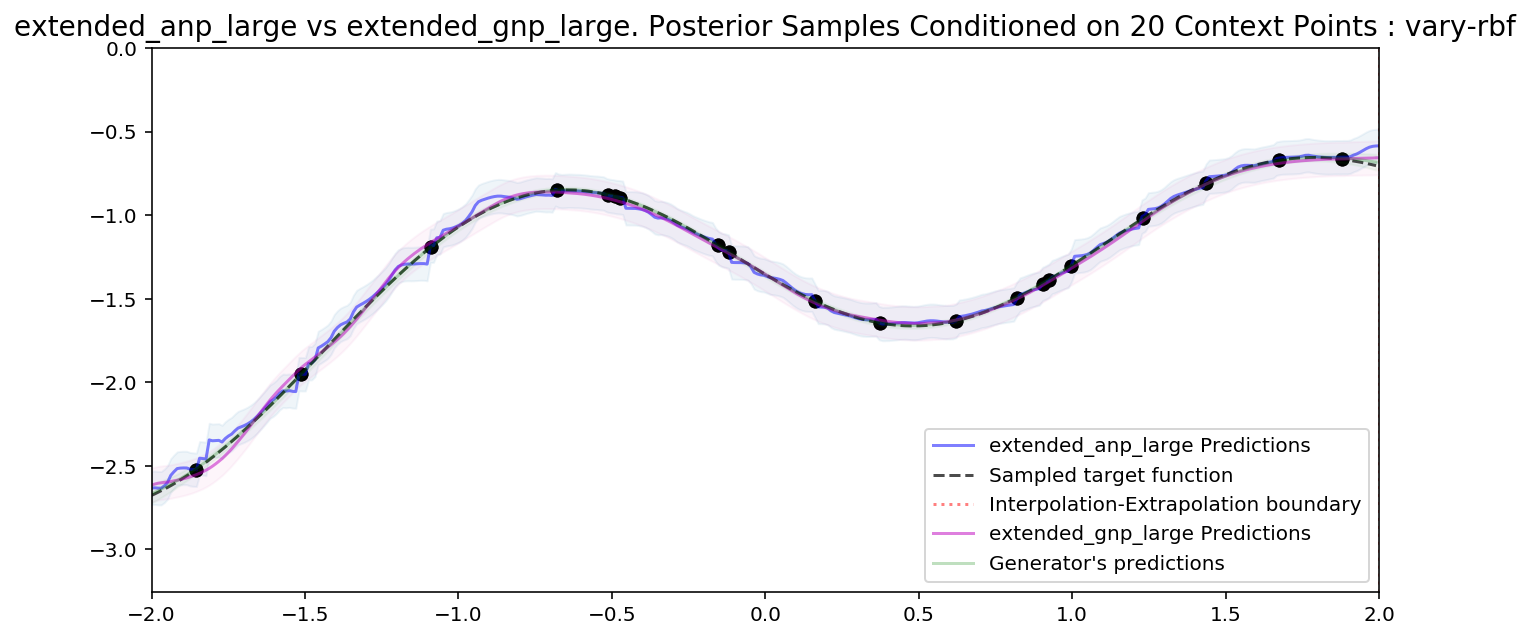

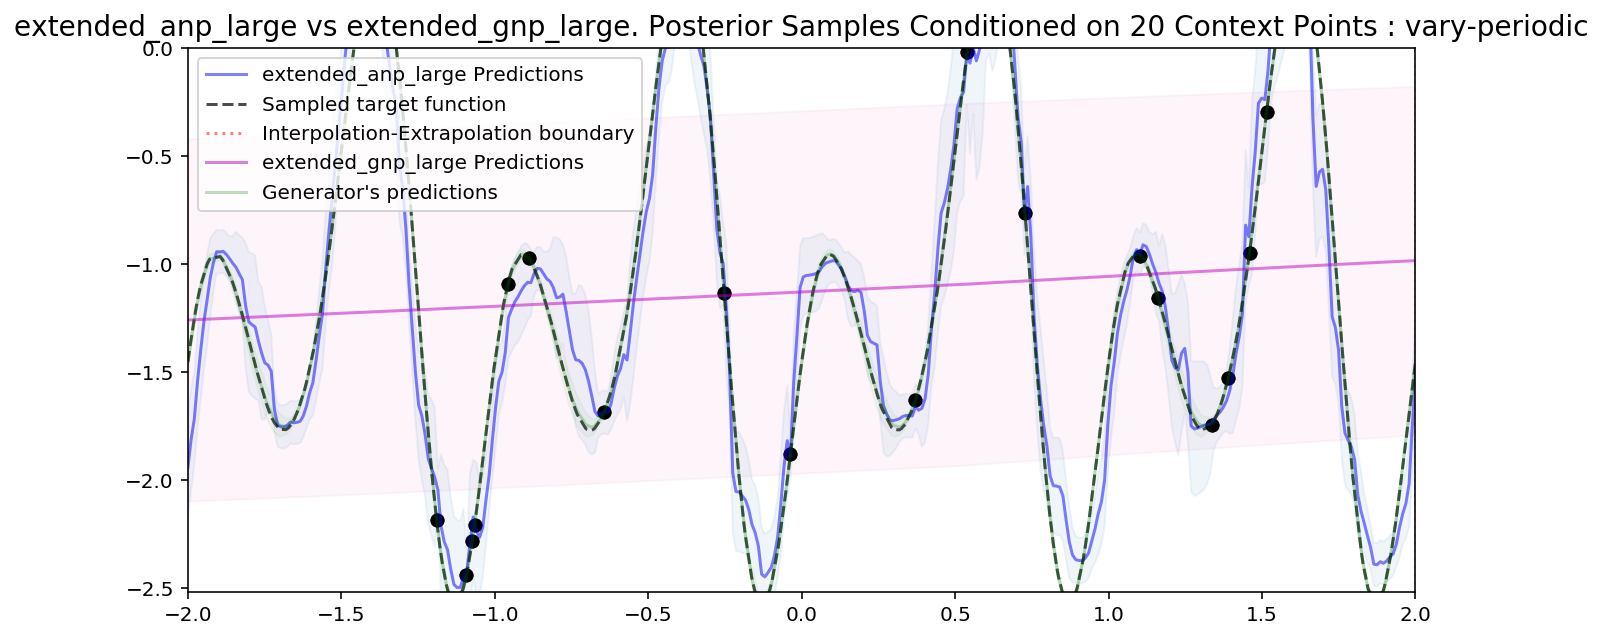

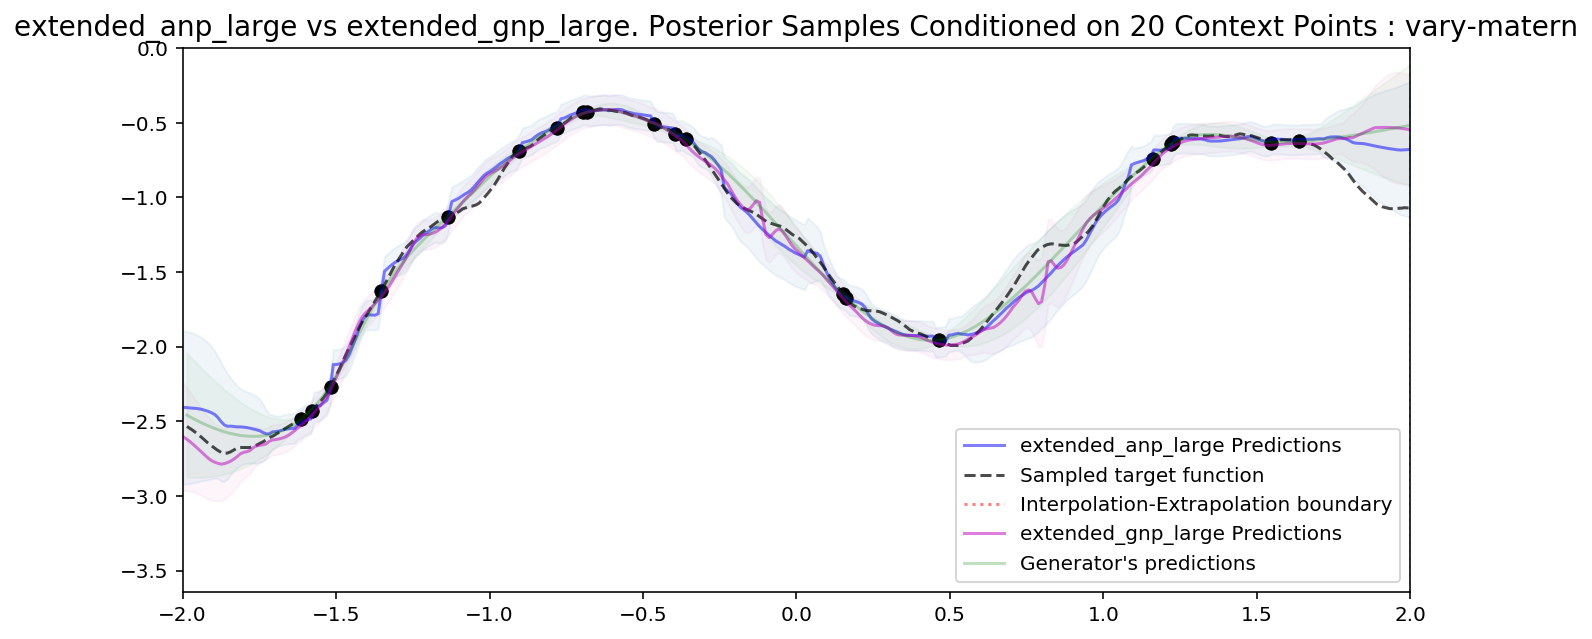

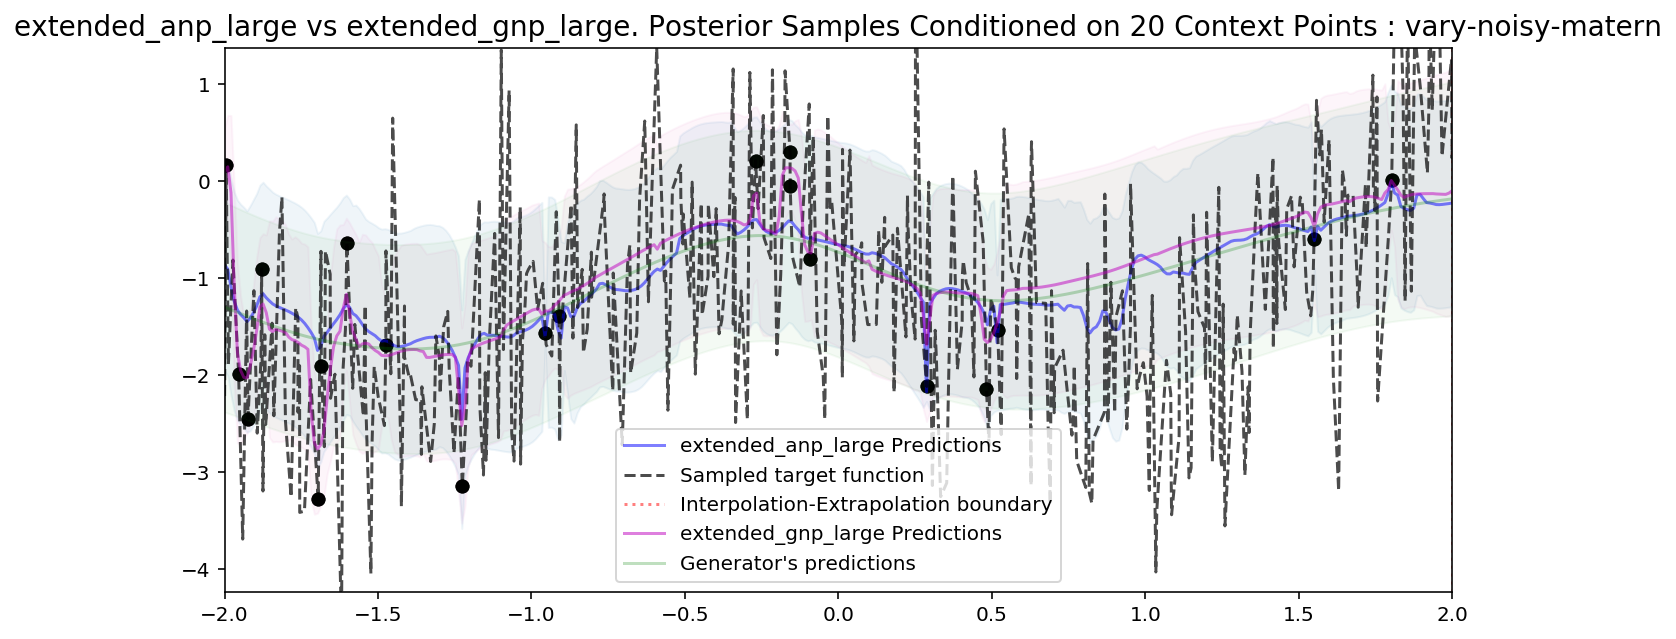

In [70]:
N_CNTXT = 20

model1 = 'extended_anp_large'
model2 = 'extended_gnp_large'

for k,(neural_proc, dataset) in loaded[model1]['data_models'].items():
    
    plot_posterior_samples(dataset, neural_proc, 
                           compare_model=loaded[model2]['data_models'][k][0],
                           model_labels=[model1, model2],
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="{} vs {}. Posterior Samples Conditioned on {} Context Points : {}".format(model1, model2, N_CNTXT, k))

In [21]:
EXTRAP_DISTANCE = 1.5  # add 1.5 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

In [22]:
for k,(neural_proc, dataset) in data_models.items():
    extrap_rescaled_range = tuple(rescale_range(np.array(EXTRAPOLATION_RANGE), (-2,2), (-1,1)))
    neural_proc.set_extrapolation(extrap_rescaled_range)

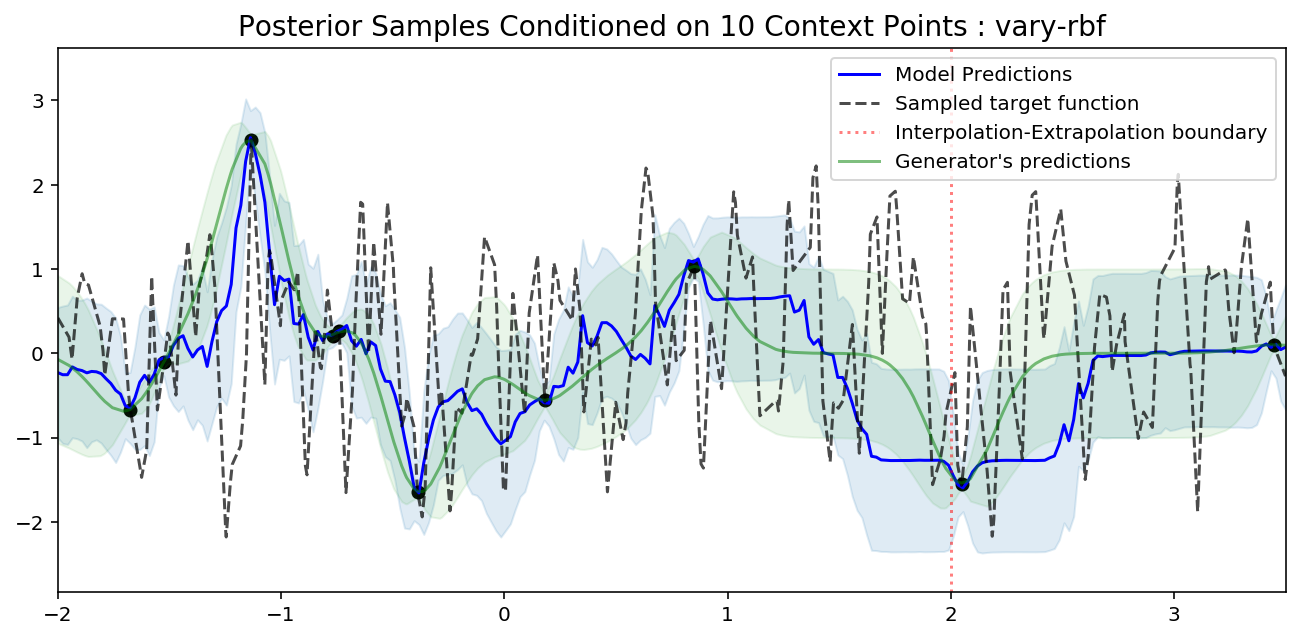

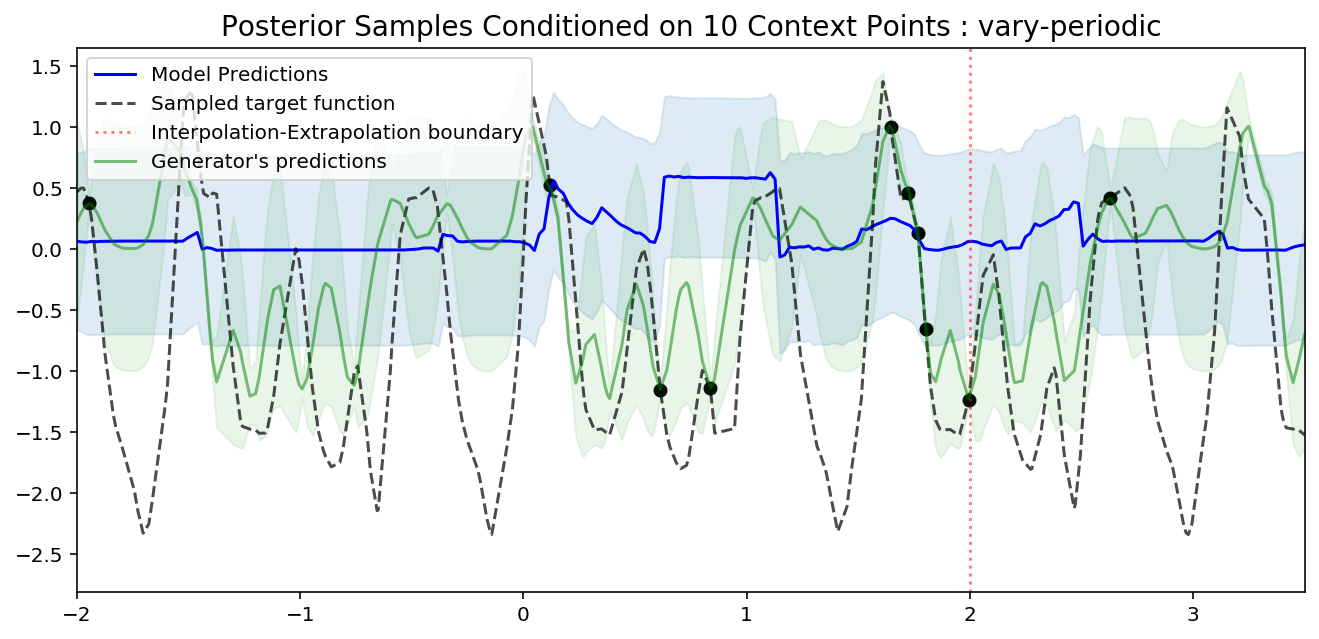

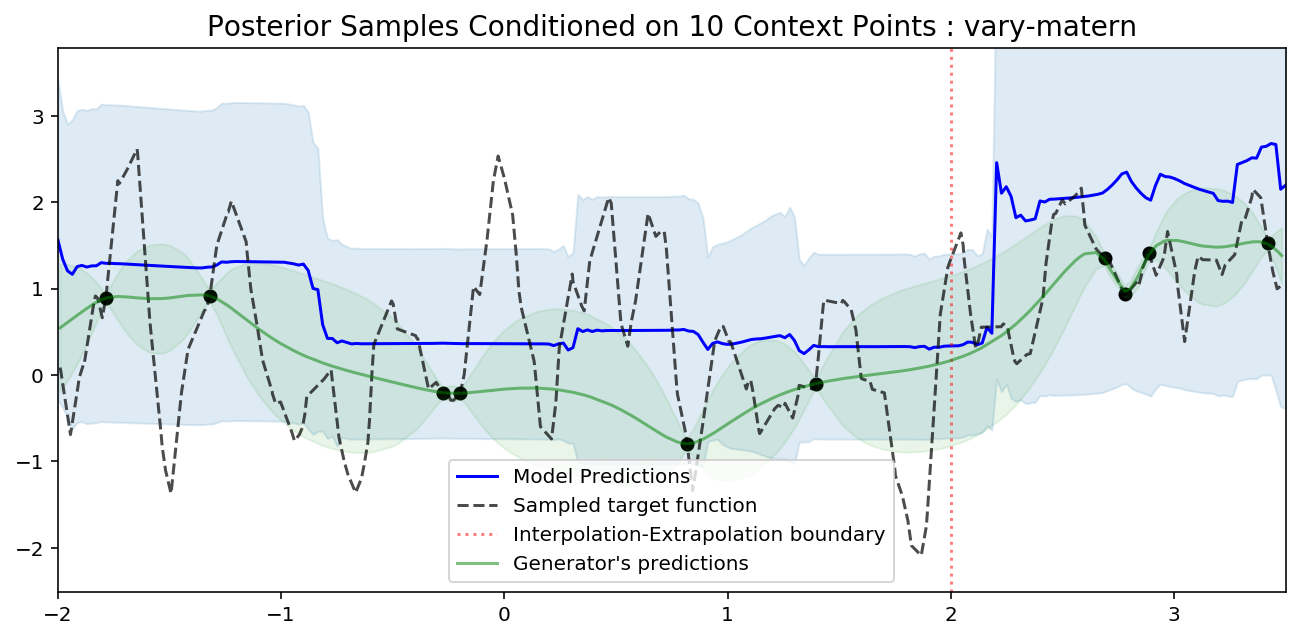

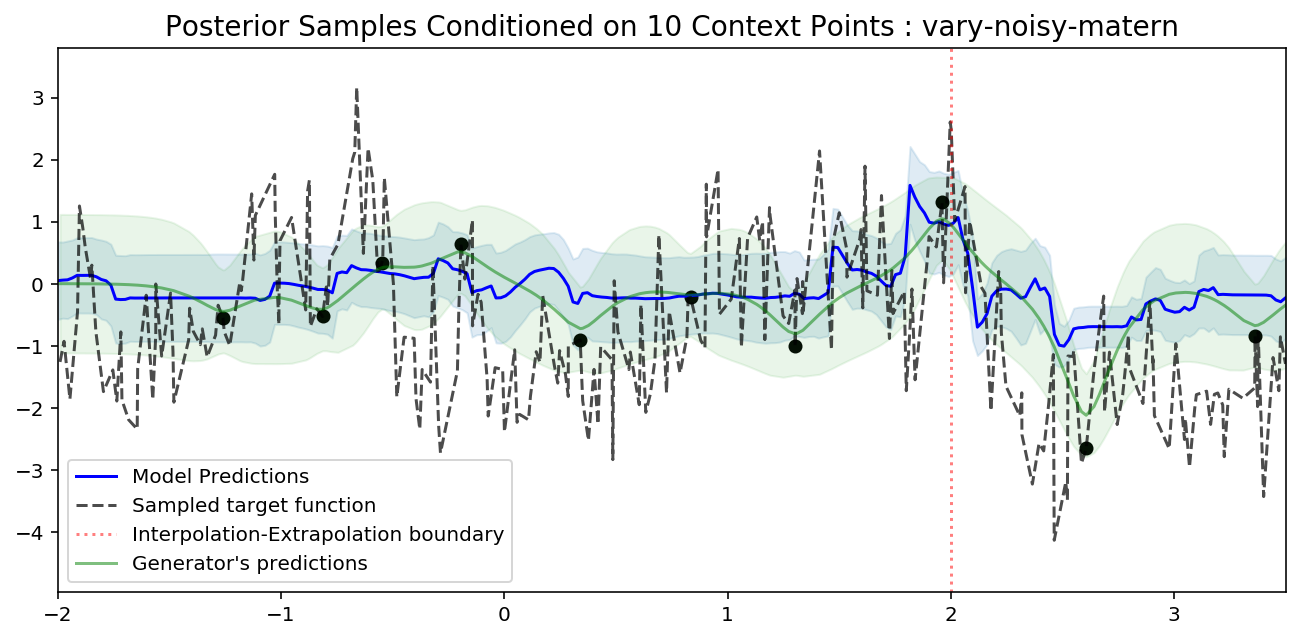

In [26]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))


In [11]:
for k,(neural_proc, dataset) in data_models.items():
    #break
    plt.figure()
    x=torch.linspace(0,0.25,100).float().unsqueeze(1)
    y=neural_proc.keys_to_tmp_attender.radial_basis_func.mlp(x).squeeze().abs()
    plt.plot(x.detach().numpy(),y.cpu().detach().numpy())

AttributeError: 'GaussianRBF' object has no attribute 'mlp'

<Figure size 432x288 with 0 Axes>

In [ ]:
exit()